In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils

### Feature group wise analysis

In [2]:
# Read ORF cosine similarities

orf_similarity_percentile_df = pd.read_parquet('cos_sim/cosine_similarities_percentile_genes_orf.parquet')

In [3]:
# Genes of interest
genes = ["NAT14", "RAB30"]

In [4]:
df = orf_similarity_percentile_df.loc[genes, genes]

for gene in genes:
    df.loc[gene, gene] = 1

In [5]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = utils.consensus(
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query('Metadata_Symbol in @genes'),
    "Metadata_JCP2022",
)

orf_profiles_with_feature_names_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00123947,G01,JCP2022_902841,RAB30,0.782264,0.545413,-1.170263,0.011855,-1.314191,...,4.948740,4.650470,4.439857,4.541978,4.479630,4.493488,4.563001,4.816595,4.602820,4.623618
1,source_4,BR00123947,E01,JCP2022_903554,NAT14,-0.072615,0.403843,-0.374025,0.036947,-0.400198,...,5.641465,5.356826,5.186027,5.262884,5.189446,5.225371,5.264193,5.514417,5.255624,5.279252


In [6]:
feature_names = utils.get_featurecols(orf_profiles_with_feature_names_df)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

In [7]:
feature_group = "AreaShape"
feature_group_list = ["Texture", "Intensity", "RadialDistribution"]
compartments = ["Cells", "Cytoplasm", "Nuclei"]
channels = ["DNA", "RNA", "Mito", "ER", "AGP"]

In [8]:
compartment_feature_group_df = pd.DataFrame()

for compartment in compartments:
    feature_cols = (
        feature_name_interpretation_df.query("feature_group==@feature_group")
        .query("compartment==@compartment")
        .feature.to_list()
    )
    feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
    id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

    cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

    df = pd.DataFrame(
        {
            "Compartment": compartment,
            "Feature_group": feature_group,
            "Similarity": cosine_sim,
        },
        index=[0],
    )

    compartment_feature_group_df = pd.concat(
        [compartment_feature_group_df, df], ignore_index=True
    )

compartment_feature_group_df = compartment_feature_group_df.pivot(
    index="Feature_group", columns="Compartment", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
print(compartment_feature_group_df.to_markdown())

| Feature_group   |    Cells |   Cytoplasm |   Nuclei |
|:----------------|---------:|------------:|---------:|
| AreaShape       | 0.205485 |    0.156733 | 0.191623 |


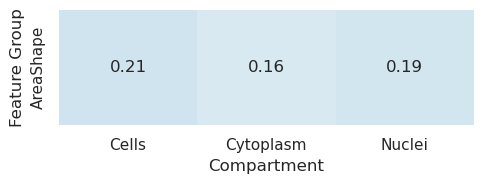

In [10]:
n_row = compartment_feature_group_df.shape[0]
n_col = compartment_feature_group_df.shape[1]
fig_width = n_row + 4
fig_height = 2
sns.set(font_scale=1)

plt.figure(figsize = (fig_width, fig_height))

f = sns.heatmap(
    compartment_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    cbar=None,
)

f.set(xlabel="Compartment", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()

plt.savefig(f"figures/{'-'.join(genes)}_area_size_compartment.png")
plt.savefig(f"figures/{'-'.join(genes)}_area_size_compartment.svg")

In [11]:
channel_feature_group_df = pd.DataFrame()

for channel in channels:
    for feature_group in feature_group_list:
        feature_cols = (
            feature_name_interpretation_df.query("feature_group==@feature_group")
            .query("channel==@channel")
            .feature.to_list()
        )
        feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
        id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

        cosine_sim = utils.cosine_similarity(id, feature_values).values[0, 1]

        df = pd.DataFrame(
            {
                "Channel": channel,
                "Feature_group": feature_group,
                "Similarity": cosine_sim,
            },
            index=[0],
        )

        channel_feature_group_df = pd.concat(
            [channel_feature_group_df, df], ignore_index=True
        )

channel_feature_group_df = channel_feature_group_df.pivot(
    index="Feature_group", columns="Channel", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
print(channel_feature_group_df.to_markdown())

| Feature_group      |      AGP |      DNA |       ER |     Mito |      RNA |
|:-------------------|---------:|---------:|---------:|---------:|---------:|
| Intensity          | 0.979585 | 0.809452 | 0.933669 | 0.95074  | 0.98562  |
| RadialDistribution | 0.786593 | 0.918739 | 0.94649  | 0.869258 | 0.916873 |
| Texture            | 0.96602  | 0.844702 | 0.914195 | 0.979294 | 0.978576 |


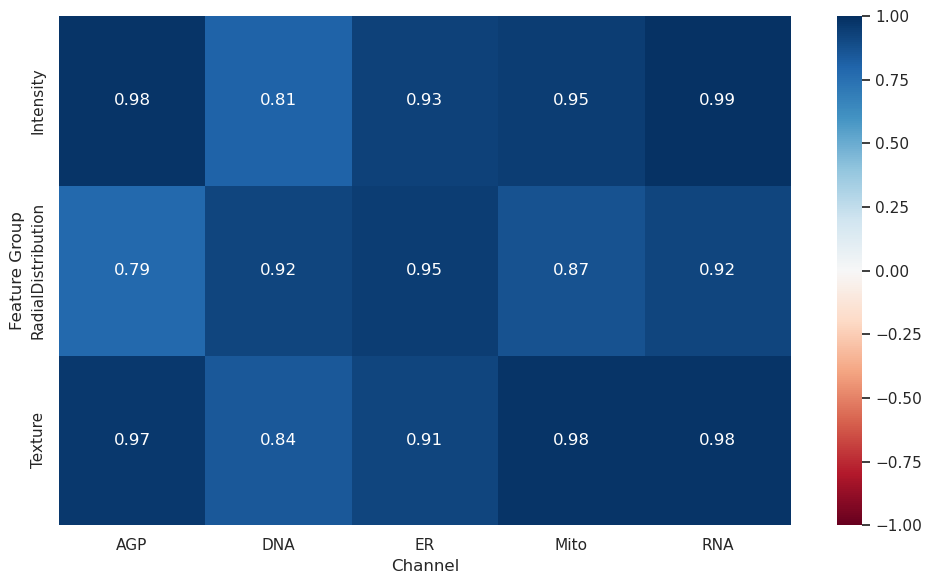

In [13]:
sns.set(font_scale=1)
plt.figure(figsize = (fig_width*2, fig_height*3))

f = sns.heatmap(
    channel_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)

f.set(xlabel="Channel", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig(f"figures/{'-'.join(genes)}_feature_group_channel.png")
plt.savefig(f"figures/{'-'.join(genes)}_feature_group_channel.svg")

### Feature wise analysis

In [14]:
jcp_id_gene_name = {
    "JCP2022_902841": "RAB30_pval",
    "JCP2022_903554": "NAT14_pval",
}

pval = 0.05

col_order = ['feature', 'compartment', 'feature_group', 'feature_type', 'channel', 'RAB30_pval', 'NAT14_pval']

In [15]:
orf_df = pd.read_parquet('../10.feature-wise-analyses/input/orf_feat_pert_pval_mwu.parquet').set_index('Feature')
orf_df.head()

,JCP2022_907604,JCP2022_906938,JCP2022_904829,JCP2022_913268,JCP2022_914563,JCP2022_903410,JCP2022_912780,JCP2022_904413,JCP2022_904180,JCP2022_914905,...,JCP2022_906442,JCP2022_911330,JCP2022_907329,JCP2022_908513,JCP2022_910221,JCP2022_905250,JCP2022_910545,JCP2022_901076,JCP2022_910969,JCP2022_908887
Feature,,,,,,,,,,,,,,,,,,,,,
Cells_AreaShape_Area,0.164502,0.075753,0.125786,0.125786,0.951170,0.198449,0.039960,0.759463,0.309690,0.005857,...,0.759463,0.439560,0.019314,0.075753,0.110375,0.055278,0.057649,0.513487,0.767899,0.953047
Cells_AreaShape_BoundingBoxArea,0.309690,0.023465,0.668170,0.057649,0.125786,0.668170,0.001332,0.581541,0.594073,0.012048,...,0.358326,0.513487,0.004662,0.158996,0.126370,0.055278,0.023465,0.953047,0.953047,0.767899
Cells_AreaShape_BoundingBoxMaximum_X,0.678655,0.023465,0.951170,0.098248,0.358326,0.297860,0.129204,0.951170,0.678655,0.854240,...,0.425983,0.055278,0.859141,0.297860,0.015876,0.859141,0.012048,0.594073,0.859141,0.767899
Cells_AreaShape_BoundingBoxMaximum_Y,0.099234,0.043297,0.016929,0.358326,0.057649,0.016929,0.678655,0.358326,0.513487,0.098248,...,0.244624,0.953047,0.370962,0.043297,0.610385,0.953047,0.004000,1.000000,0.206460,0.513487
Cells_AreaShape_BoundingBoxMinimum_X,0.594073,0.012048,0.854240,0.198449,0.425983,0.581541,0.439560,0.759463,0.439560,0.854240,...,0.358326,0.055278,0.859141,0.297860,0.005934,0.678655,0.004000,0.513487,0.859141,0.678655


In [16]:
#JCP ID of interest

jcp_id = list(orf_profiles_with_feature_names_df.Metadata_JCP2022)

In [17]:
orf_df = (
    orf_df[jcp_id]
    .reset_index()
    .rename(columns={"Feature": "feature"})
    .rename(columns=jcp_id_gene_name)
)
orf_df.head()

,feature,RAB30_pval,NAT14_pval
0,Cells_AreaShape_Area,0.000666,0.012654
1,Cells_AreaShape_BoundingBoxArea,0.000666,0.000666
2,Cells_AreaShape_BoundingBoxMaximum_X,0.370962,0.039960
3,Cells_AreaShape_BoundingBoxMaximum_Y,0.370962,0.953047
4,Cells_AreaShape_BoundingBoxMinimum_X,0.594073,0.075258


In [18]:
feature_names = list(orf_df.feature.values)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

In [19]:
# Remove Correlation features
feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.feature.str.contains("Correlation")
]

# Remove Object Number features

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.feature.str.contains("ObjectNumber")
]

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.feature.str.contains("Object_Number")
]

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.channel.str.contains("XNONE")
]

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.channel.str.contains("YNONE")
]

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.feature_type.str.contains("XNONE")
]

feature_name_interpretation_df = feature_name_interpretation_df[
    ~feature_name_interpretation_df.feature_type.str.contains("YNONE")
]

In [20]:
orf_df = orf_df.merge(feature_name_interpretation_df, on="feature", how="inner")

orf_df = orf_df.query("RAB30_pval < @pval and NAT14_pval < @pval")

In [21]:
orf_df[col_order].to_csv('output/RAB30-NAT14-all-significant-features.csv.gz', index=False)

In [22]:
nat14_df = orf_df.sort_values(by="NAT14_pval", ascending=True).drop_duplicates(subset=["compartment", "feature_group", "feature_type"])

nat14_df[col_order].to_csv('output/RAB30-NAT14-top-features-nat14.csv.gz', index=False)

In [23]:
rab30_df = orf_df.sort_values(by="RAB30_pval", ascending=True).drop_duplicates(subset=["compartment", "feature_group", "feature_type"])

rab30_df[col_order].to_csv('output/RAB30-NAT14-top-features-rab30.csv.gz', index=False)

Genes most similar to RAB30 and NAT14

In [24]:
df = orf_similarity_percentile_df.loc[:, ["NAT14", "RAB30"]]

genes = df.sort_values(by="NAT14", ascending=False).head(10).index.to_list() + df.sort_values(by="RAB30", ascending=False).head(10).index.to_list()

genes = np.unique(genes)

In [25]:
profiles = (
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query("Metadata_Symbol in @genes")
)

profiles = profiles.drop_duplicates(subset=["Metadata_Symbol", "Metadata_Well"])

profiles = profiles[["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"]]

plates = pd.read_csv('../datasets/metadata/plate.csv.gz', usecols=["Metadata_Batch", "Metadata_Plate"])

profiles = profiles.merge(plates, on="Metadata_Plate", how="inner")

print(profiles.to_markdown(index=False))

| Metadata_Symbol   | Metadata_Plate   | Metadata_Well   | Metadata_Batch    |
|:------------------|:-----------------|:----------------|:------------------|
| CLDN3             | BR00123947       | I01             | 2021_06_07_Batch5 |
| SRI               | BR00123947       | O01             | 2021_06_07_Batch5 |
| SOCS2             | BR00123947       | M01             | 2021_06_07_Batch5 |
| ALMS1P1           | BR00123947       | C01             | 2021_06_07_Batch5 |
| PPCDC             | BR00123947       | A01             | 2021_06_07_Batch5 |
| RAB30             | BR00123947       | G01             | 2021_06_07_Batch5 |
| NAT14             | BR00123947       | E01             | 2021_06_07_Batch5 |
| TREML2            | BR00123952       | I01             | 2021_06_07_Batch5 |
| IL26              | BR00123952       | C13             | 2021_06_07_Batch5 |
| IL26              | BR00123952       | C01             | 2021_06_07_Batch5 |
| ASPDH             | BR00123952       | G01        

In [26]:
# Check the contents of plates

wells = ["A21", "C05", "C08", "E01", "E02", "E07", "E14", "F22", "G01", "J05", "J11"]
plate = "BR00123947"

wells_df = pd.read_csv('../datasets/metadata/well.csv.gz').query("Metadata_Plate == @plate").query("Metadata_Well in @wells")

wells_df = wells_df.merge(orf_metadata_df, on="Metadata_JCP2022", how="inner").sort_values(by="Metadata_Well")

print(wells_df[["Metadata_Plate", "Metadata_Well", "Metadata_Symbol"]].to_markdown(index=False))

| Metadata_Plate   | Metadata_Well   | Metadata_Symbol   |
|:-----------------|:----------------|:------------------|
| BR00123947       | A21             | LUCIFERASE        |
| BR00123947       | C05             | BFP               |
| BR00123947       | C08             | BFP               |
| BR00123947       | E01             | NAT14             |
| BR00123947       | E02             | LacZ              |
| BR00123947       | E07             | HcRed             |
| BR00123947       | E14             | LUCIFERASE        |
| BR00123947       | F22             | LacZ              |
| BR00123947       | G01             | RAB30             |
| BR00123947       | J05             | LUCIFERASE        |
| BR00123947       | J11             | BFP               |


Genes showing that plate layout effects still exist.

In [27]:
genes_to_plot = profiles.query("Metadata_Plate==@plate").Metadata_Symbol.to_list()

location = profiles.query("Metadata_Plate==@plate").Metadata_Well.to_list()

gene_location = [f"{location[i]}_{genes_to_plot[i]}" for i in range(len(genes_to_plot))]

df = orf_similarity_percentile_df.loc[genes_to_plot, genes_to_plot]

for gene in genes_to_plot:
    df.loc[gene, gene] = 1

df = pd.DataFrame(df.values, index=gene_location, columns=gene_location)

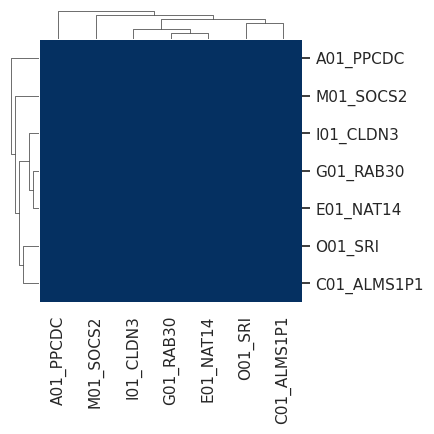

In [28]:
# Plot the heatmap

n_row = df.shape[0]
n_col = df.shape[1]
fig_width = n_row * 0.5 + 1
fig_height = n_col * 0.5 + 1

g = sns.clustermap(
    df,
    cmap="RdBu",
    vmin=0,
    vmax=1,
    dendrogram_ratio=(0.1, 0.1),
    figsize=(fig_width, fig_height),
    cbar_pos=None,
)

#set title
g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")

plt.savefig(f"figures/spurious-connections-{'-'.join(genes_to_plot)}.png", dpi=300)
plt.savefig(f"figures/spurious-connections-{'-'.join(genes_to_plot)}.svg", dpi=300)